In [1]:
import numpy as np
import pandas as pd
import os
import tqdm
from scipy.stats import kstest,ttest_ind,fisher_exact
from scipy.stats.contingency import odds_ratio
import itertools as it
from collections import Counter
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 7, 'ytick.major.width': 1.5, 'ytick.major.size': 7})
from matplotlib.backends.backend_pdf import PdfPages
from functools import reduce
from scipy.stats import kstest,ttest_ind

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [2]:
phenotype_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/phenotype/data/bmi_processed/british/train_cohort_bmi.csv.gz"
cohort_files = [
    "/data6/deepro/ukb_bmi/3_characterization/data/combo_info/british/discovery_combo2.csv",
    "/data6/deepro/ukb_bmi/3_characterization/data/combo_info/british/discovery_combo3.csv"
]

phenotype_df = pd.read_csv(phenotype_file)


cohort_df = pd.concat([pd.read_csv(cf) for cf in cohort_files])
all_combo_samples = set("|".join(cohort_df.combo_samples.values).split("|"))

In [6]:
def get_bmi_cat(bmi):
    """
    underweight refers to a BMI of less than 18.5 kg/m2, 
    normal as 18.5 to 24.9 kg/m2, 
    overweight as 25.0 to 29.9 kg/m2, 
    obesity as 30.0 to 39.9 kg/m2, 
    and severe obesity as 40 kg/m2 or more
    """
    bmi_cat = ""
    if bmi<18.5:
        bmi_cat = "underweight"
    elif bmi<24.9:
        bmi_cat = "normal"
    elif bmi<29.9:
        bmi_cat = "overweight"
    elif bmi<39.9:
        bmi_cat = "obese"
    else:
        bmi_cat = "severe obesity"

    return bmi_cat

In [7]:
phenotype_df["bmi_prs_decile"] = pd.qcut(phenotype_df.bmi_prs, q=10)
phenotype_df["bmi_prs_decile_num"] = pd.qcut(phenotype_df.bmi_prs, q=10, labels=False)
phenotype_df["bmi_categories"] = phenotype_df.bmi.apply(get_bmi_cat)
phenotype_df["bmi_prs_categories"] = phenotype_df.bmi_prs_decile_num.map({
    0: "lowest", 
    1:"middle", 2:"middle", 
    3:"middle", 4:"middle", 5:"middle", 6:"middle", 7:"middle",
    8:"middle", 9:"highest"
    })
phenotype_combo_samples_df = phenotype_df.loc[phenotype_df.sample_names.astype(str).isin(list(map(str, all_combo_samples)))]
phenotype_other_samples_df = phenotype_df.loc[~phenotype_df.sample_names.astype(str).isin(list(map(str, all_combo_samples)))]

phenotype_other_samples_df["description"] = "Non Combo"
phenotype_combo_samples_df["description"] = "Combo"
phenotype_samples_df = pd.concat((phenotype_combo_samples_df, phenotype_other_samples_df))

/tmp/ipykernel_86284/2259667620.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype_other_samples_df["description"] = "Non Combo"
/tmp/ipykernel_86284/2259667620.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype_combo_samples_df["description"] = "Combo"


In [11]:
def get_prs_percent(df):
    df1 = df.groupby("bmi_categories")["bmi_prs_categories"].value_counts(normalize=True)
    df1 = df1.mul(100)
    df1 = df1.rename('percent').reset_index()
    max_bmi_dict = df.groupby("bmi_categories")["bmi"].max().to_dict()
    return df1, max_bmi_dict

In [12]:
phenotype_combo_samples_plot_df, cbmi_dict = get_prs_percent(phenotype_combo_samples_df)
phenotype_other_samples_plot_df, ncbmi_dict = get_prs_percent(phenotype_other_samples_df)


/tmp/ipykernel_86284/475937989.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.ax.set_xticklabels([f"{l.get_text()}\n{round(cbmi_dict[l.get_text()], 2)}" for l in g.ax.get_xticklabels()])


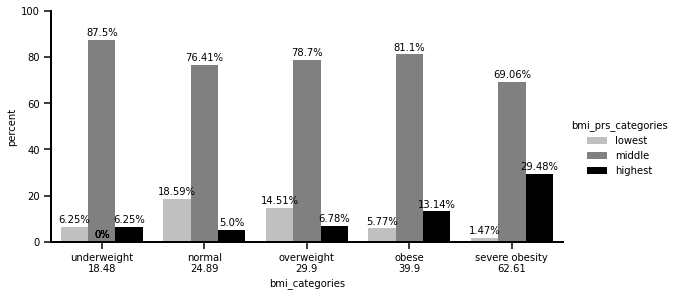

In [13]:
g = sns.catplot(data=phenotype_combo_samples_plot_df, 
    x="bmi_categories",
    y="percent",
    hue="bmi_prs_categories", 
    kind="bar",
    height=4, aspect=2,
    order=["underweight", "normal", "overweight", "obese", "severe obesity"],
    hue_order=["lowest", "middle", "highest"],
    palette=["silver", "gray", "black"]
    )

g.ax.set_ylim(0,100)
g.ax.set_xticklabels([f"{l.get_text()}\n{round(cbmi_dict[l.get_text()], 2)}" for l in g.ax.get_xticklabels()])

rects = g.ax.patches
for rect in rects:
    height = rect.get_height()
    g.ax.text(
        rect.get_x() + rect.get_width() / 2, height + 1, f"{round(height, 2)}%", ha="center", va="bottom"
    )

/tmp/ipykernel_86284/1190682270.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.ax.set_xticklabels([f"{l.get_text()}\n{round(ncbmi_dict[l.get_text()], 2)}" for l in g.ax.get_xticklabels()])


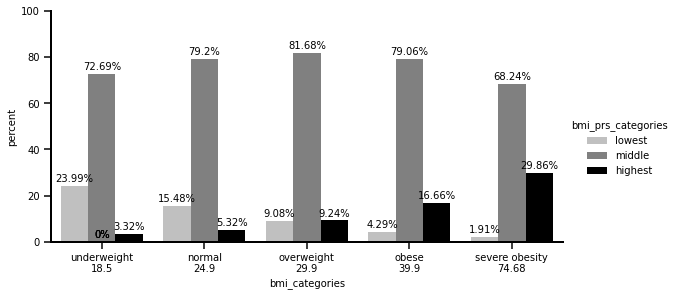

In [14]:
g = sns.catplot(data=phenotype_other_samples_plot_df, 
    x="bmi_categories",
    y="percent",
    hue="bmi_prs_categories", 
    kind="bar",
    height=4, aspect=2,
    order=["underweight", "normal", "overweight", "obese", "severe obesity"],
    hue_order=["lowest", "middle", "highest"],
    palette=["silver", "gray", "black"]
    )

g.ax.set_ylim(0,100)
g.ax.set_xticklabels([f"{l.get_text()}\n{round(ncbmi_dict[l.get_text()], 2)}" for l in g.ax.get_xticklabels()])

rects = g.ax.patches
for rect in rects:
    height = rect.get_height()
    g.ax.text(
        rect.get_x() + rect.get_width() / 2, height + 1, f"{round(height, 2)}%", ha="center", va="bottom"
    )


In [15]:
def get_prs_percent(df):
    df1 = df.groupby("bmi_prs_categories")["bmi_categories"].value_counts(normalize=True)
    df1 = df1.mul(100)
    df1 = df1.rename('percent').reset_index()
    max_bmi_dict = df.groupby("bmi_categories")["bmi"].max().to_dict()
    return df1, max_bmi_dict

In [16]:
phenotype_combo_samples_plot_df, cbmi_dict = get_prs_percent(phenotype_combo_samples_df)
phenotype_other_samples_plot_df, ncbmi_dict = get_prs_percent(phenotype_other_samples_df)

/tmp/ipykernel_86284/475937989.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.ax.set_xticklabels([f"{l.get_text()}\n{round(cbmi_dict[l.get_text()], 2)}" for l in g.ax.get_xticklabels()])


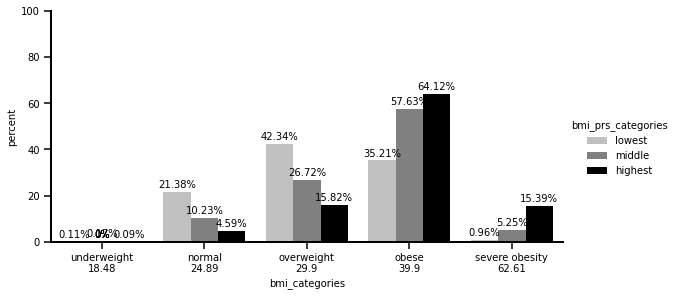

In [17]:
g = sns.catplot(data=phenotype_combo_samples_plot_df, 
    x="bmi_categories",
    y="percent",
    hue="bmi_prs_categories", 
    kind="bar",
    height=4, aspect=2,
    order=["underweight", "normal", "overweight", "obese", "severe obesity"],
    hue_order=["lowest", "middle", "highest"],
    palette=["silver", "gray", "black"]
    )

g.ax.set_ylim(0,100)
g.ax.set_xticklabels([f"{l.get_text()}\n{round(cbmi_dict[l.get_text()], 2)}" for l in g.ax.get_xticklabels()])

rects = g.ax.patches
for rect in rects:
    height = rect.get_height()
    g.ax.text(
        rect.get_x() + rect.get_width() / 2, height + 1, f"{round(height, 2)}%", ha="center", va="bottom"
    )

/tmp/ipykernel_86284/1190682270.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.ax.set_xticklabels([f"{l.get_text()}\n{round(ncbmi_dict[l.get_text()], 2)}" for l in g.ax.get_xticklabels()])


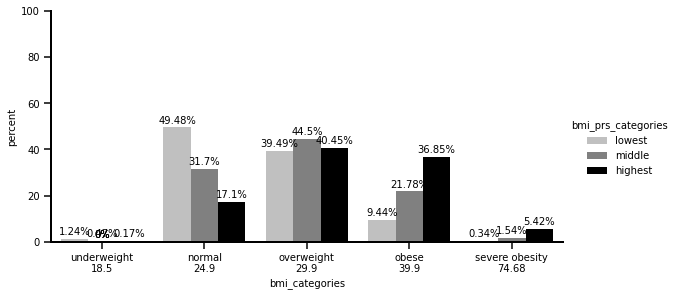

In [18]:
g = sns.catplot(data=phenotype_other_samples_plot_df, 
    x="bmi_categories",
    y="percent",
    hue="bmi_prs_categories", 
    kind="bar",
    height=4, aspect=2,
    order=["underweight", "normal", "overweight", "obese", "severe obesity"],
    hue_order=["lowest", "middle", "highest"],
    palette=["silver", "gray", "black"]
    )

g.ax.set_ylim(0,100)
g.ax.set_xticklabels([f"{l.get_text()}\n{round(ncbmi_dict[l.get_text()], 2)}" for l in g.ax.get_xticklabels()])

rects = g.ax.patches
for rect in rects:
    height = rect.get_height()
    g.ax.text(
        rect.get_x() + rect.get_width() / 2, height + 1, f"{round(height, 2)}%", ha="center", va="bottom"
    )


<AxesSubplot: xlabel='bmi_res_categories', ylabel='percent'>

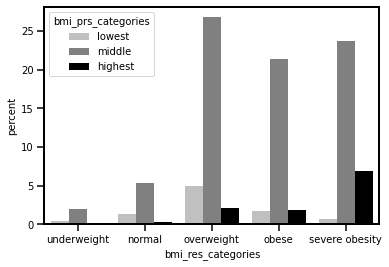

In [14]:
sns.countplot(
    data=phenotype_combo_samples_df, 
    x="bmi_res_categories", 
    hue="bmi_prs_categories", 
    stat="percent",
    order=["underweight", "normal", "overweight", "obese", "severe obesity"],
    hue_order=["lowest", "middle", "highest"],
    palette=["silver", "gray", "black"])

<AxesSubplot: xlabel='bmi_res_categories', ylabel='percent'>

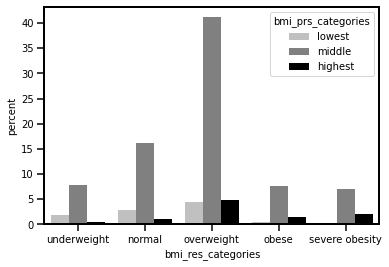

In [15]:
sns.countplot(
    data=phenotype_other_samples_df, 
    x="bmi_res_categories", 
    hue="bmi_prs_categories", 
    stat="percent",
    order=["underweight", "normal", "overweight", "obese", "severe obesity"],
    hue_order=["lowest", "middle", "highest"],
    palette=["silver", "gray", "black"])

In [16]:
phenotype_other_samples_df

,sample_names,sex,genetic_kinship_to_other_participants,genetic_ethnic_grouping,genetic_sex,year_of_birth,bmi_prs,genetic_pca1,genetic_pca2,genetic_pca3,...,age,bmi_scaled,bmi_residuals,bmi_res_decile,bmi_res_decile_num,bmi_prs_decile,bmi_prs_decile_num,bmi_res_categories,bmi_prs_categories,description
0,1000028,Male,No kinship found,Caucasian,1,1947.0,-0.652309,-1.049343,-0.035594,-0.318610,...,1.053334,-0.400313,-0.524182,"(-0.571, -0.364]",3,"(-0.722, -0.458]",3,overweight,middle,Non Combo
1,1000045,Female,At least one relative identified,Caucasian,0,1952.0,-1.084330,-0.375479,-0.102603,-0.511934,...,-0.190425,-0.777059,-0.693161,"(-0.797, -0.571]",2,"(-1.463, -1.034]",1,normal,middle,Non Combo
2,1000171,Female,No kinship found,Caucasian,0,1944.0,-0.980411,-0.382776,-0.734280,0.182330,...,1.426462,0.738413,0.792503,"(0.693, 1.278]",8,"(-1.034, -0.722]",2,obese,middle,Non Combo
3,1000196,Female,No kinship found,NaN,0,1959.0,0.032952,9.739123,-21.189125,-11.847223,...,-0.563553,-1.646162,-1.508422,"(-3.191, -1.088]",0,"(-0.21, 0.0383]",5,underweight,middle,Non Combo
4,1000222,Male,No kinship found,Caucasian,1,1940.0,0.092755,0.531430,0.476652,-0.542410,...,1.302086,0.545706,0.384838,"(0.34, 0.693]",7,"(0.0383, 0.302]",6,overweight,middle,Non Combo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427633,6024818,Male,No kinship found,Caucasian,1,1942.0,-0.416108,0.307354,0.304317,-0.321877,...,0.928958,0.042139,-0.102653,"(-0.155, 0.0721]",5,"(-0.458, -0.21]",4,overweight,middle,Non Combo
427634,6024948,Male,No kinship found,Caucasian,1,1953.0,0.321514,0.166423,0.526967,-0.109158,...,-0.314801,4.162986,4.109587,"(1.278, 9.928]",9,"(0.302, 0.612]",7,severe obesity,middle,Non Combo
427636,6025119,Male,At least one relative identified,Caucasian,1,1957.0,0.968325,0.028790,-0.315907,-0.332173,...,-0.252613,0.560394,0.447395,"(0.34, 0.693]",7,"(0.612, 1.041]",8,overweight,middle,Non Combo
427637,6025181,Male,No kinship found,Caucasian,1,1964.0,-0.119517,0.053980,-0.853161,-0.321771,...,-1.558560,-0.191185,-0.198597,"(-0.364, -0.155]",4,"(-0.21, 0.0383]",5,overweight,middle,Non Combo
